# Homework 8 - Andrew Schwartz - PHYS 403, SPR 2024

## 1. Detailed Balance and the Metropolis-Hastings Algorithm

The Metropolis-Hastings algorithm is based on the transition probability
$$
p(x_t,x_{t+1})=p(x_t|D)p(x_{t+1}|x_t)=p(x_t|D)q(x_{t+1}|t_x)\alpha(x_t,x_{t+1}),
$$
where the acceptance distribution $\alpha$ is defined by the ration
$$
\alpha(x_t,x_{t+1})=\text{min}\left\{1,\frac{p(x_{t+1}|D)}{p(x_t|D)}\frac{q(x_t|x_{t+1})}{q(x_{t+1}|x_t)}\right\}.
$$
Show that the Metropolis-Hastings algorithm obeys the principle of detailed balance. That is, show that 
$$
p(x_t|D)\;p(x_{t+1}|x_t)=p(x_{t+1}|D)\;p(x_t|x_{t+1})
$$

## Solution



The proof is an exercise left to the reader. (I ran out of time)

## 2. Boltzmann's Constant and Avogadro's Number

In 1908 Jean Baptiste Perrin measured Boltzmann’s constant $k_B$ in an experiment based on Brownian motion. The experiment was conducted by observing particles of mastic, a substance used in varnish, suspended in water. The particles were spheres of radius $r$ = 0.52 µm and had a density of 1.063 g cm$^{−3}$. By viewing the particles through a microscope, only those in a layer approximately 1 µm thick were in focus; particles outside this layer were not visible. By adjusting the microscope lens, the focal plane could be moved vertically. The number of particles $n(z)$ were counted at four different heights $z$:

| height $z$ (μm) | number of particles $n$ |
|-----------------|-------------------------|
| 0               | 1880                    |
| 6               | 940                     |
| 12              | 530                     |
| 18              | 305                     |

A statistical mechanical argument shows that $n(z)$ is distributed like a Poisson variable with expected value $$
v(z)=v_0 \exp\left\{-\frac{4\pi r^3 \Delta \rho g z}{3 k_B T}\right\}, \quad \Delta\rho=0.063 \text{ g cm}^{-2}, \quad g=980 \text{ cm s}^{-2}, \quad T=290 \text{ K}.
$$ 
Thus you can maximize a Poisson log-likelihood and estimate free parameters $v_0$ and $k_B$.

### (a)

Using Markov Chain Monte Carlo, sample $v_0$ and $k_B$ from the PDF
$$ p(v_0,k_B|D,I)\propto p(D|v_0,k_B,I)p(v_0|I)p(k_B|I) $$
where $p(D|ν_0, k_B, I)$ is the Poisson log-likelihood. Assume uniform priors on $ν_0$ and $k_B$, and seed the MCMC using points from a neighborhood around the maximum likelihood values $(\hat ν_0, \hat k_B)$. Plot the time series of $ν_0$ and $k_B$.


In [63]:
# setup
import corner
import emcee
from emcee import autocorr
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from prettytable import PrettyTable

π = np.pi  # 🥧
Δρ = 0.063  # g cm⁻²
g = 980  # cm s⁻²
T = 290  # L
r = 0.52  # μm?? that's sketchy
r /= 10000  # cm

zs = np.array([0, 6, 12, 18], dtype=float)  # μm
zs /= 10000  # cm
ns = np.array([1880, 940, 530, 305])

Log likelihood

$$ 
\begin{align}
L(D|v,I)=&\sum_{i=1}^N -\lambda_i+ x_i\ln\lambda_i-\ln x_i! \\
=& \sum_{i=1}^N -\lambda_i+x_i\ln\lambda_i-(x_i\ln x_i-x_i)
\end{align}
$$
where $D$ is our data (${(z_i,n_i)}$), and $\lambda_i \equiv v(z_i)$.

In [65]:
def logl(v0, kB):
    λs = v0 * np.exp(-(4 * π * r ** 3 * Δρ * g * zs) / (3 * kB * T))
    return np.sum(-λs + ns * np.log(λs) - (ns * np.log(ns) + ns))


nlogl = lambda args: -logl(*args)
# mle = minimize(nlogl, [1, 1]).x
# mle = minimize(nlogl, [1800, 1.2e-16], bounds=[(0, 10000), (0.01, 10000)], method='Nelder-Mead').x
mle = minimize(nlogl, [1800, 1e-16], method='Nelder-Mead').x
mle_v0, mle_kB = mle
print(f"mle_v0, mle_kB = {mle}")
mle_kB

mle_v0, mle_kB = [1.84494450e+03 1.21110283e-16]


1.211102831867062e-16

In [85]:
def log_priors(v0, kB):
    if 0.0 < v0 < 2 * mle_v0 and 1e-18 < kB < 2 * mle_kB:
        return 0.0
    return -np.inf


def log_prob(p):
    v0, kB = p
    lp = log_priors(v0, kB)
    if not np.isfinite(lp):
        return -np.inf
    return lp + logl(v0, kB)


pos = mle * (1 + 1e-5 * np.random.randn(32, len(mle)))

sampler = emcee.EnsembleSampler(*pos.shape, log_prob)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:08<00:00, 616.07it/s]


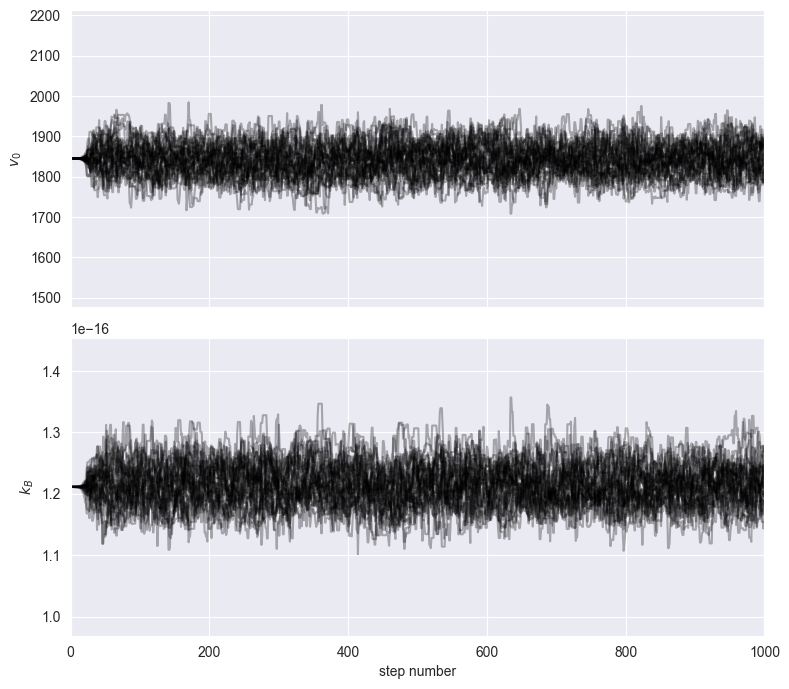

In [87]:
fig, axes = plt.subplots(2, 1, figsize=(8, 7), sharex=True)
samples = sampler.get_chain()

labels = ['$v_0$', '$k_B$']
yrange = np.outer(mle, [0.8, 1.2])
for i in range(2):
    ax = axes[i]
    ax.plot(samples[:1000, :, i], 'k', alpha=0.3)
    ax.set(xlim=(0, 1000), ylim=yrange[i], ylabel=labels[i])
    # ax.yaxis.set_label_coords(-0.11, 0.5)

axes[-1].set_xlabel('step number')
fig.tight_layout()

### (b)

Compute the autocorrelation time τ of the MCMC samples and plot the autocorrelation function. Then discard the burn-in steps in the MCMC (some multiple of $\tau$) and thin the chain. The thinning factor can be about half the autocorrelation time.

[30.54604081 29.52163687]
30


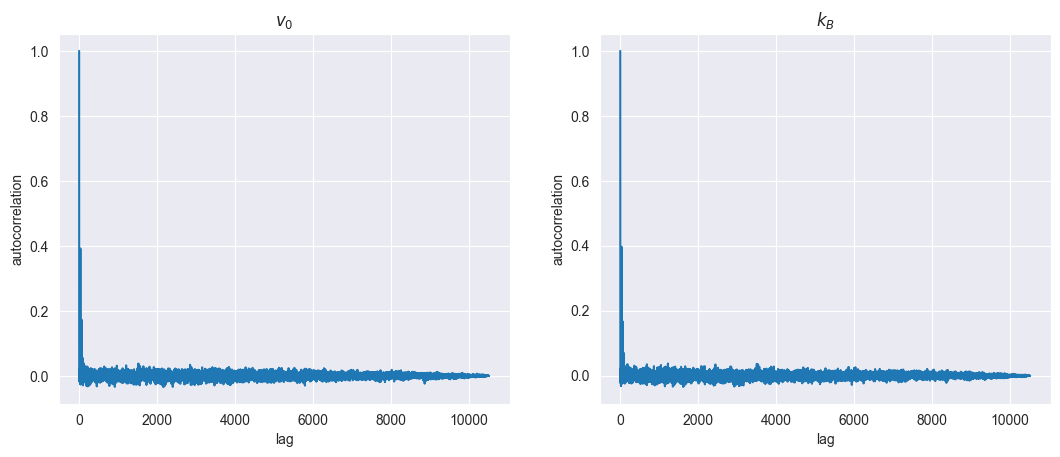

In [68]:
tau = sampler.get_autocorr_time()
print(tau)
tau = int(np.max(tau))
print(tau)
flat_samples = sampler.get_chain(discard=2 * tau, thin=tau // 2, flat=True)

fig, ax = plt.subplots(1, 2, figsize=(6.4 * 2, 4.8))
for i in range(2):
    ax[i].plot(autocorr.function_1d(flat_samples[:, i]))
    ax[i].set(
        xlabel='lag',
        ylabel='autocorrelation',
        title=['$v_0$', '$k_B$'][i]
    )

### (c)

Make a corner plot of your post-burn-in samples and comment on any correlation you observe between $ν_0$ and $k_B$. Estimate the maximum *a posteriori* (MAP) values of the parameters from the mode of the distribution, as well as the central 68% credible intervals.

In [104]:
v0mean, kbmean = np.mean(flat_samples, axis=0)
v0quantile, kbquantile = np.quantile(flat_samples, [0.16, 0.84], axis=0).T
sigmas = [-np.subtract.reduce(q) / 2 for q in [v0quantile, kbquantile]]

t = PrettyTable(["", "v₀", "kB"])
t.add_row(["MAP", v0mean, kbmean])
t.add_row(["68% lower bound", v0quantile[0], kbquantile[0]])
t.add_row(["68% upper bound", v0quantile[1], kbquantile[1]])
t.add_row(["sigma", *sigmas])
print(t)

+-----------------+--------------------+------------------------+
|                 |         v₀         |           kB           |
+-----------------+--------------------+------------------------+
|       MAP       | 1849.8257623993513 | 1.2073328988695144e-16 |
| 68% lower bound | 1810.4267671066636 | 1.1736187857392344e-16 |
| 68% upper bound | 1888.8591241708018 | 1.240207799963545e-16  |
|      sigma      | 39.21617853206908  |  3.32945071121553e-18  |
+-----------------+--------------------+------------------------+


$$ 
\begin{align}
v_0&=1849.83±39.22\\
k_B&=(1.207 ± 0.033) \times 10^{-16}
\end{align}
$$

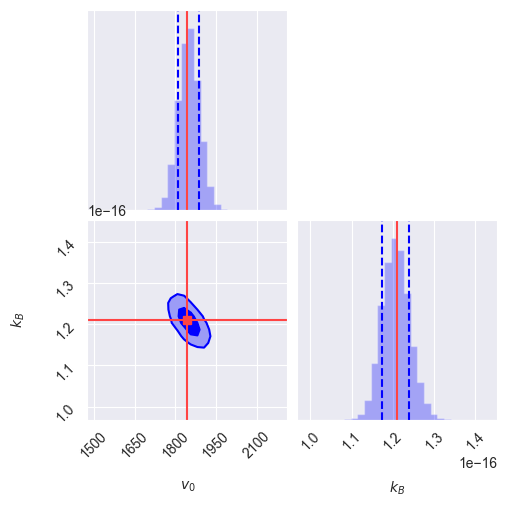

In [105]:
fig = corner.corner(flat_samples, labels=labels,
                    range=yrange, bins=30,  #smooth=1,
                    truths=mle, truth_color='#ff4444',
                    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)), quantiles=(0.16, 0.84),
                    hist_kwargs={'histtype': 'stepfilled', 'alpha': 0.3},
                    color='blue', plot_datapoints=False,
                    fill_contours=True);

My comment on correlations: Anti! And both look gaussian which I think is good?

### (d)

From the MCMC samples of $k_B$ you can estimate Avogadro’s number using the relation
$$N_A = R/k_B,$$
where $R = 8.32 × 10^7 \text{ erg mol}^{−1}\text{ K}^{-1}$ is the value of the ideal gas constant used by Perrin. Compute both the MAP value and credible interval of $N_A$.

In [117]:
R = 8.32 * 10 ** 7  # erg mol⁻¹ K⁻¹

NA = R / kbmean
interval = (R / kbquantile)[::-1]  # reverse to get low->high ordering

sigma = (interval[1] - interval[0]) / 2

t = PrettyTable(['', 'NA'])
t.add_row(['MAP', NA])
t.add_row(["68% lower bound", interval[0]])
t.add_row(["68% upper bound", interval[1]])
t.add_row(["sigma", sigma])
print(t)

+-----------------+------------------------+
|                 |           NA           |
+-----------------+------------------------+
|       MAP       | 6.857819675787859e+23  |
| 68% lower bound | 6.675417471363168e+23  |
| 68% upper bound | 7.050483474050562e+23  |
|      sigma      | 1.8753300134369713e+22 |
+-----------------+------------------------+


$$ N_A=(6.857+0.188)\times 10^{23} $$

### (e)

Regenerate the MCMC sample using a uniform prior on $ν_0$ and Jeffrey’s prior for $k_B$. Do your results change significantly, and if so, why?

100%|██████████| 5000/5000 [00:09<00:00, 507.26it/s]


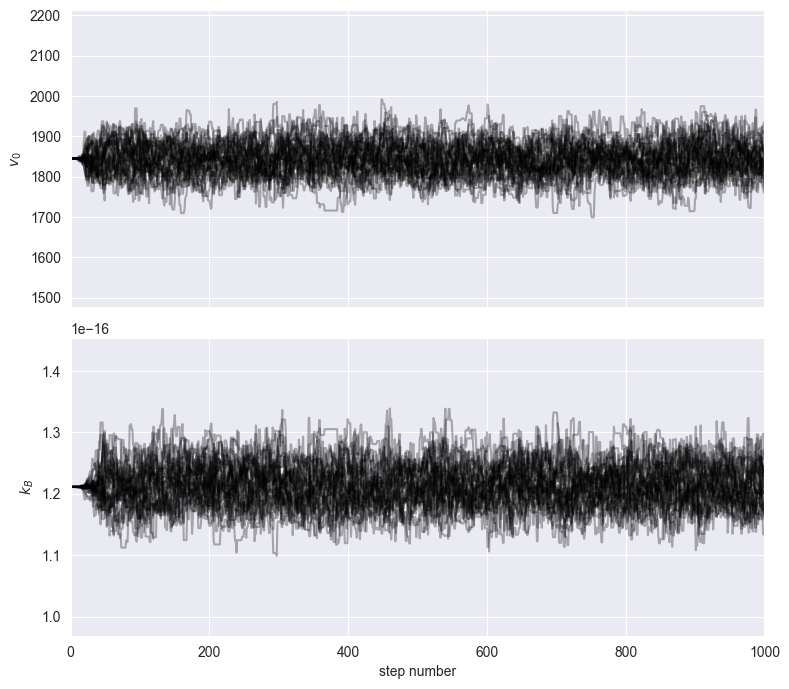

In [120]:
def log_jeffreys(v0, kB):
    if 0.0 < v0 < 2 * mle_v0 and 1e-18 < kB < 2 * mle_kB:
        return np.log(1 / kB / np.log(2 * mle_kB / 1e-18))
    return -np.inf


def log_prob(p):
    v0, kB = p
    lp = log_jeffreys(v0, kB)
    if not np.isfinite(lp):
        return -np.inf
    return lp + logl(v0, kB)


pos = mle * (1 + 1e-5 * np.random.randn(32, len(mle)))

sampler = emcee.EnsembleSampler(*pos.shape, log_prob)
sampler.run_mcmc(pos, 5000, progress=True);

fig, axes = plt.subplots(2, 1, figsize=(8, 7), sharex=True)
samples = sampler.get_chain()

labels = ['$v_0$', '$k_B$']
yrange = np.outer(mle, [0.8, 1.2])
for i in range(2):
    ax = axes[i]
    ax.plot(samples[:1000, :, i], 'k', alpha=0.3)
    ax.set(xlim=(0, 1000), ylim=yrange[i], ylabel=labels[i])

axes[-1].set_xlabel('step number')
fig.tight_layout()

In [121]:
tau = sampler.get_autocorr_time()
print(tau)
tau = int(np.max(tau))
print(tau)
flat_samples = sampler.get_chain(discard=2 * tau, thin=tau // 2, flat=True)

[32.42911418 33.86640142]
33


In [122]:
v0mean, kbmean = np.mean(flat_samples, axis=0)
v0quantile, kbquantile = np.quantile(flat_samples, [0.16, 0.84], axis=0).T
sigmas = [-np.subtract.reduce(q) / 2 for q in [v0quantile, kbquantile]]

t = PrettyTable(["", "v₀", "kB"])
t.add_row(["MAP", v0mean, kbmean])
t.add_row(["68% lower bound", v0quantile[0], kbquantile[0]])
t.add_row(["68% upper bound", v0quantile[1], kbquantile[1]])
t.add_row(["sigma", *sigmas])
print(t)

+-----------------+--------------------+------------------------+
|                 |         v₀         |           kB           |
+-----------------+--------------------+------------------------+
|       MAP       | 1845.7965999381279 | 1.2127202934143752e-16 |
| 68% lower bound | 1806.7782833177228 | 1.179249146633121e-16  |
| 68% upper bound | 1884.6912341755356 | 1.2461348300899266e-16 |
|      sigma      |  38.9564754289064  | 3.344284172840281e-18  |
+-----------------+--------------------+------------------------+


$$ 
\begin{align}
v_0&=1844.68±38.90 \\
k_B&=(1.21 ± 0.032) \times 10^{-16}
\end{align}
$$

Our results are almost entirely unchanged. This makes sense, as Jeffrey's prior is very small for our problem.

### (f)

How does the estimate you obtain for $N_A$ differ from the current CODATA standard value? Is the difference statistically significant? Comment on possible systematic effects in Perrin’s determination of $N_A$ that may explain discrepancies.

In [123]:
NA = R / kbmean
interval = (R / kbquantile)[::-1]  # reverse to get low->high ordering

sigma = (interval[1] - interval[0]) / 2

t = PrettyTable(['', 'NA'])
t.add_row(['MAP', NA])
t.add_row(["68% lower bound", interval[0]])
t.add_row(["68% upper bound", interval[1]])
t.add_row(["sigma", sigma])
print(t)

+-----------------+------------------------+
|                 |           NA           |
+-----------------+------------------------+
|       MAP       | 6.860609198329902e+23  |
| 68% lower bound | 6.676645094174595e+23  |
| 68% upper bound | 7.055336884283076e+23  |
|      sigma      | 1.8934589505424054e+22 |
+-----------------+------------------------+


$$ N_A=(6.861+0.189)\times 10^{23} $$
CODATA value: $$ 6.022\,140\,76  \times 10^{23} $$

In [124]:
(NA - 6.02214076e23) / sigma

4.428236683397401

This value is 4.4 sigmas away from the CODATA value, meaning it is a significantly large (≥3σ) discrepancy. Some systematic errors in Perrin's determination might be that it was the olden times and so he just couldn't afford precise or accurate numbers (sorry I ran out of time).